In [1]:
from tqdm.notebook import tqdm
import numpy as np
import sys
sys.path.append('../')
from partitioning import is_pow_of_two, init_membership_list
from spawn import start_db_background
from structures import Params, NetworkParams
from client_dynamo import client_get, client_put
from parallel_runner import run_parallel
from random import randint

import logging
logger = logging.getLogger('dynamo_node')
logger.setLevel(logging.ERROR)

START_PORT = 2333
CLIENT_ID = 1

def get_start_port(randomize=True):
    return START_PORT + randint(0, params.num_proc-1) * int(randomize)

def get_stats(durations):
    if len(durations) == 0:
        return {}
    durations = np.array(durations) # convert from seconds to ms
    mean = np.mean(durations)
    std = np.std(durations)
    nnth = np.percentile(durations, 99.9)
    return {'mean': mean, 'std': std, '99.9th': nnth}

def generate_plot(durations, label='', clear=True):
    if clear:
        plt.clf()
    fig = sns.distplot(durations, label=label)
    plt.ylabel('Density')
    plt.xlabel('Response Time (in ms)')
    plt.title('Distribution of response times (in ms)')
    plt.legend()
    plt.show()

params = {
    'num_proc' : 8,
    'hash_size': 8, # 2^3 = 8 
    'Q' : 16, # 
    'N' : 4,
    'w_timeout': 2,
    'r_timeout': 2,
    'R': 1,
    'W': 3,
    'gossip': False
}
network_params = {
    'latency': 10,
    'randomize_latency': False,
    'drop_prob': 0
}

params = Params(params)
network_params = NetworkParams(network_params)
membership_information = init_membership_list(params)

16 and True
8 and True
Configuration is as follows: Key space sizes 256
Total V Nodes 16 | V Nodes Per Proc 2


In [2]:
processes_future = start_db_background(params, membership_information, network_params, wait=True, start_port=START_PORT)

Membership Info {0: [9, 13], 1: [5, 12], 2: [1, 4], 3: [6, 8], 4: [2, 15], 5: [14, 0], 6: [10, 3], 7: [7, 11]} NUmber of processes 8
0
--------Starting process with params: Loading config..
num_proc : 8
hash_size : 8
Q : 16
N : 4
w_timeout : 2
r_timeout : 2
R : 1
W : 3
gossip : False

here False
not here
------------------start Python GRPC server at localhost:2333
1
--------Starting process with params: Loading config..
num_proc : 8
hash_size : 8
Q : 16
N : 4
w_timeout : 2
r_timeout : 2
R : 1
W : 3
gossip : False

here False
not here
------------------start Python GRPC server at localhost:2334
2
--------Starting process with params: Loading config..
num_proc : 8
hash_size : 8
Q : 16
N : 4
w_timeout : 2
r_timeout : 2
R : 1
W : 3
gossip : False

here False
not here
------------------start Python GRPC server at localhost:2335
3
--------Starting process with params: Loading config..
num_proc : 8
hash_size : 8
Q : 16
N : 4
w_timeout : 2
r_timeout : 2
R : 1
W : 3
gossip : False

here False
n

In [3]:
def run_multiple_get(total, num_requests, get_durations):
    for i in tqdm(range(total // num_requests)):
        requests = [client_get]*num_requests
        requests_params = [{'port': get_start_port(), 'client_id': CLIENT_ID, 'key': randint(0, 2**params.hash_size-1)} for _ in range(num_requests)]
        get_durations = np.concatenate((get_durations, run_parallel(requests, requests_params, start_port=START_PORT)))
    return get_durations

def run_multiple_put(total, num_requests, put_durations):
    for i in tqdm(range(total // num_requests)):
        requests = [client_put]*num_requests
        k = randint(0, 2**params.hash_size-1)
        requests_params = [{'port': get_start_port(), 'client_id': CLIENT_ID, 'key': k, 'val': str(k)} for _ in range(num_requests)]
        put_durations = np.concatenate((put_durations, run_parallel(requests, requests_params, start_port=START_PORT)))
    return put_durations

def store_keys(params):
    for key in tqdm(range(2**params.hash_size)):
        client_put(get_start_port(), CLIENT_ID, key=key, val=str(key))

In [4]:
store_keys(params)

In [5]:
context=None
response = client_put(get_start_port(), CLIENT_ID, key=16, val="16", context=context)

response = client_get(get_start_port(), CLIENT_ID, key=1)
context = response.items[0].context

In [17]:
get_durations = np.array([])
get_durations = run_multiple_get(1000, 10, get_durations)
get_durations *= 1000

In [18]:
get_durations.shape

(1000,)

In [20]:
get_durations.mean(), get_durations.std()

(26.208847999572754, 4.892119309256952)

In [21]:
stats_get = get_stats(get_durations)

In [22]:
for k,v in stats_get.items():
    print(f'{k}: {v:.2f} ms')

mean: 26.21 ms
std: 4.89 ms
99.9th: 35.26 ms


In [32]:
put_durations = np.array([])
put_durations = run_multiple_put(1000, 10, put_durations)
put_durations *= 1000

In [33]:
put_durations.shape

(1000,)

In [35]:
put_stats = get_stats(put_durations)

In [36]:
for k,v in put_stats.items():
    print(f'{k}: {v:.2f} ms')

mean: 44.31 ms
std: 5.84 ms
99.9th: 79.99 ms


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

/opt/miniconda3/envs/dynamo/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/dynamo/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


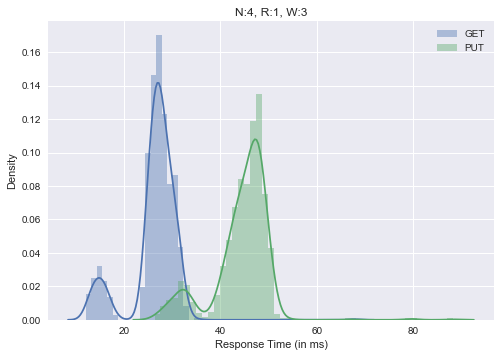

In [38]:
fig = sns.distplot(get_durations, label='GET')
fig = sns.distplot(put_durations, label='PUT')
plt.ylabel('Density')
plt.xlabel('Response Time (in ms)')
plt.title('N:4, R:1, W:3')
plt.legend()
plt.show()

## With failures

In [5]:
import logging
logger = logging.getLogger('dynamo_node')
logger.setLevel(logging.INFO)
logger.propagate = False

def get_start_port(randomize=True, failed_port=None):
    new_port = START_PORT + randint(0, params.num_proc-1) * int(randomize)
    while failed_port is not None and new_port == failed_port:
        new_port = START_PORT + randint(0, params.num_proc-1) * int(randomize)
    return new_port

def run_multiple_get(total, num_requests, get_durations=None, failed_port=None):
    durations, responses = [], []
    for i in tqdm(range(total // num_requests)):
        requests = [client_get]*num_requests
        requests_params = [{'port': get_start_port(failed_port=failed_port), 'client_id': CLIENT_ID, 'key': randint(0, 2**params.hash_size-1)} for _ in range(num_requests)]
        _durations, _responses = run_parallel(requests, requests_params, start_port=START_PORT, as_np=False)
        print(len(_durations))
        durations.extend(_durations)
        responses.extend(_responses)
    return durations, responses

In [6]:
from client_dynamo import client_fail

client_fail(START_PORT)

In [7]:
response = client_put(START_PORT+1, CLIENT_ID, 0, "0")
print(response)

response = client_get(START_PORT+1, CLIENT_ID, 0)
print(response)

ERROR:grpc._server:Exception calling application: 
Traceback (most recent call last):
  File "/opt/miniconda3/envs/dynamo/lib/python3.8/site-packages/grpc/_server.py", line 435, in _call_behavior
    response_or_iterator = behavior(argument, context)
  File "../dynamo_node.py", line 315, in Put
    raise concurrent.futures.CancelledError # retirning None will result in failure
concurrent.futures._base.CancelledError


_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "Exception calling application: "
	debug_error_string = "{"created":"@1607554502.575614000","description":"Error received from peer ipv6:[::1]:2333","file":"src/core/lib/surface/call.cc","file_line":1062,"grpc_message":"Exception calling application: ","grpc_status":2}"
>

In [10]:
# get_fail_durations = np.array([])
get_fail_durations, responses = run_multiple_get(30, 10, None, START_PORT)

0 []
0
0 []
0
0 []
0



In [9]:
get_fail_durations = np.array(get_fail_durations)

get_fail_durations.shape

(10,)

In [13]:
len(get_fail_durations)

1

In [12]:
get_fail_durations*1000

array([ 27.10199356, 132.25102425, 113.0759716 ])

In [11]:
len(responses)

10

In [20]:
get_durations.shape

NameError: name 'get_durations' is not defined

In [1]:
test = [0.029925823211669922, 0.03148627281188965, 0.031996965408325195, 0.03176593780517578, 0.031462907791137695, 0.030453920364379883, 0.03252911567687988, 0.0177609920501709, 0.1620798110961914, 0.2121727466583252, 0.22617697715759277, 0.2506279945373535, 0.24697089195251465, 0.29291319847106934, 0.4482302665710449, 0.40848278999328613, 0.48263120651245117]

In [2]:
len(test)

17